# Schrodinger equation
---

$$
\begin{aligned}
\varepsilon u_t - i\frac{\epsilon^2}{2}\Delta u + i V(x)u = 0, \ t \in \mathbb{R}, x\in \mathbb{R}^d, \\
u(x, t = 0) = u_0(x),
\end{aligned}
$$
where $V$ is a given electrostatic potential, $0 < \varepsilon \ll 1$.

---

Example 2 in Shi Jin's paper:
$$
u(x, 0) = \sqrt{n_0(x)}e^{iS_0(x)/\varepsilon},
$$
(3.9-3.10)
$$
n_0(x) = (e^{-25(x-0.5)^2})^2, \ S_0(x) = 0.2(x^2 - x).
$$

Periodic BC.

---

Consider the real and imag part of $u$, i.e., 
$$
u(x, t) = p(x, t) + iq(x, t),
$$
then
$$
\begin{aligned}
&\varepsilon p_t+\frac{\varepsilon^2}{2}q_{xx} - V(x)q = 0, \\
&\varepsilon q_t-\frac{\varepsilon^2}{2}p_{xx} + V(x)p = 0,
\end{aligned}
$$
with ic
$$
p(x, 0) = e^{-25(x-0.5)^2}\cos(\frac{0.2(x^2-x)}{\varepsilon}), \ q(x, 0) = e^{-25(x-0.5)^2}\sin(\frac{0.2(x^2-x)}{\varepsilon}),
$$
and bc
$$
p(0, t) = p(1, t), q(0, t) = q(1, t), p_x(0, t) = p_x(1, t), q_x(0, t) = q_x(1, t).
$$

In [1]:
NAME = "3_siren_time_marching_sampling"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [2] + [64]*4 + [2] # (x, t) -> (u, v)
c0 = 1.0
w0 = jnp.array([[1.0], [10.0]]) # (w_x, w_t)
# w0 = 1.0
w1 = 1.0
lambda_0 = 1e-8
direct_params = init_siren_params(subkey, layers, c0, w0, w1)
# direct_params = init_tanh_params(subkey, layers)

domain = jnp.array([[0., 0.], [1., 0.5]])
epsilon = 1.0
V = 1.0

@jax.jit
def model(params, xt):
	# first, normalize to [-1, 1]
	xt = 2.0*(xt - domain[0, :])/(domain[1, :]-domain[0, :]) - 1.0
	for w, b in params[:-1]:
# 		xt = jax.nn.swish(jnp.dot(xt, w) + b)
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
# uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
# u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
# duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
# du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
# duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
# du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0]

# uv_l = model(direct_params, jnp.hstack([periodic_bc.l, periodic_bc.t]))
# uv_r = model(direct_params, jnp.hstack([periodic_bc.r, periodic_bc.t]))
# u_l, v_l = uv_l[:, 0:1], uv_l[:, 1:2]
# u_r, v_r = uv_r[:, 0:1], uv_r[:, 1:2]

# duv_dxt_l = jacobian(direct_params, jnp.hstack([periodic_bc.l, periodic_bc.t]))
# duv_dxt_r = jacobian(direct_params, jnp.hstack([periodic_bc.r, periodic_bc.t]))
# du_dx_l, dv_dx_l = duv_dxt_l[:, 0:1, 0], duv_dxt_l[:, 1:2, 0]
# du_dx_r, dv_dx_r = duv_dxt_r[:, 0:1, 0], duv_dxt_r[:, 1:2, 0]

# uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
# u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]

In [5]:
# 	loss_c1 = metaloss(epsilon*du_dt_c + 0.5*epsilon**2*dv_dxx_c - V*v_c, 0)
# 	loss_c2 = metaloss(epsilon*dv_dt_c - 0.5*epsilon**2*du_dxx_c + V*u_c, 0)
# 	loss_c = loss_c1 + loss_c2
	
# 	loss_d1 = metaloss(u_d, dirichlet.u)
# 	loss_d2 = metaloss(v_d, dirichlet.v)
# 	loss_d = loss_d1 + loss_d2
	
# 	loss_pbc_d1 = metaloss(u_l, u_r)
# 	loss_pbc_d2 = metaloss(v_l, v_r)
# 	loss_pbc_n1 = metaloss(du_dx_l, du_dx_r)
# 	loss_pbc_n2 = metaloss(dv_dx_l, dv_dx_r)
# 	loss_pbc_d = loss_pbc_d1 + loss_pbc_d2
# 	loss_pbc_n = loss_pbc_n1 + loss_pbc_n2

In [6]:
metaloss = mae

jit_conservation = lambda i: jax.partial(jax.jit, static_argnums = i)

@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, periodic_bc = batch["collocation"], batch["dirichlet"], batch["periodic_bc"]
	direct_params = params
	
	uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
	u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
	
	# jacobian[i] = [[du/dx, du/dt],
	#                [dv/dx, dv/dt]]
	# i: the i^th input
	duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
	
	# hessian[i] = [
    #				[[du/dxx, du/dxy],
	#                [du/dxy, du/dyy]],
	#               [[dv/dxx, dv/dxy],
	#                [dv/dxy, dv/dyy]]
	#              ]
	duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0] 
	
	uv_l = model(direct_params, jnp.hstack([periodic_bc.l, periodic_bc.t]))
	uv_r = model(direct_params, jnp.hstack([periodic_bc.r, periodic_bc.t]))
	u_l, v_l = uv_l[:, 0:1], uv_l[:, 1:2]
	u_r, v_r = uv_r[:, 0:1], uv_r[:, 1:2]
	
	duv_dxt_l = jacobian(direct_params, jnp.hstack([periodic_bc.l, periodic_bc.t]))
	duv_dxt_r = jacobian(direct_params, jnp.hstack([periodic_bc.r, periodic_bc.t]))
	du_dx_l, dv_dx_l = duv_dxt_l[:, 0:1, 0], duv_dxt_l[:, 1:2, 0]
	du_dx_r, dv_dx_r = duv_dxt_r[:, 0:1, 0], duv_dxt_r[:, 1:2, 0]
		
	uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
	u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
	
	loss_c1 = metaloss(epsilon*du_dt_c + 0.5*epsilon**2*dv_dxx_c - V*v_c, 0)
	loss_c2 = metaloss(epsilon*dv_dt_c - 0.5*epsilon**2*du_dxx_c + V*u_c, 0)
	loss_c = loss_c1 + loss_c2
	
	loss_d1 = metaloss(u_d, dirichlet.u)
	loss_d2 = metaloss(v_d, dirichlet.v)
	loss_d = loss_d1 + loss_d2
	
	loss_pbc_d1 = metaloss(u_l, u_r)
	loss_pbc_d2 = metaloss(v_l, v_r)
	loss_pbc_n1 = metaloss(du_dx_l, du_dx_r)
	loss_pbc_n2 = metaloss(dv_dx_l, dv_dx_r)
	loss_pbc_d = loss_pbc_d1 + loss_pbc_d2
	loss_pbc_n = loss_pbc_n1 + loss_pbc_n2
	
	return loss_c, loss_d, loss_pbc_d, loss_pbc_n


@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_pbc_d, loss_pbc_n = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + w["pbc_d"]*loss_pbc_d + w["pbc_n"]*loss_pbc_n + l2_regularization(params, lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_pbc_d, loss_pbc_n = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + w["pbc_d"]*loss_pbc_d + w["pbc_n"]*loss_pbc_n, loss_c, loss_d, loss_pbc_d, loss_pbc_n

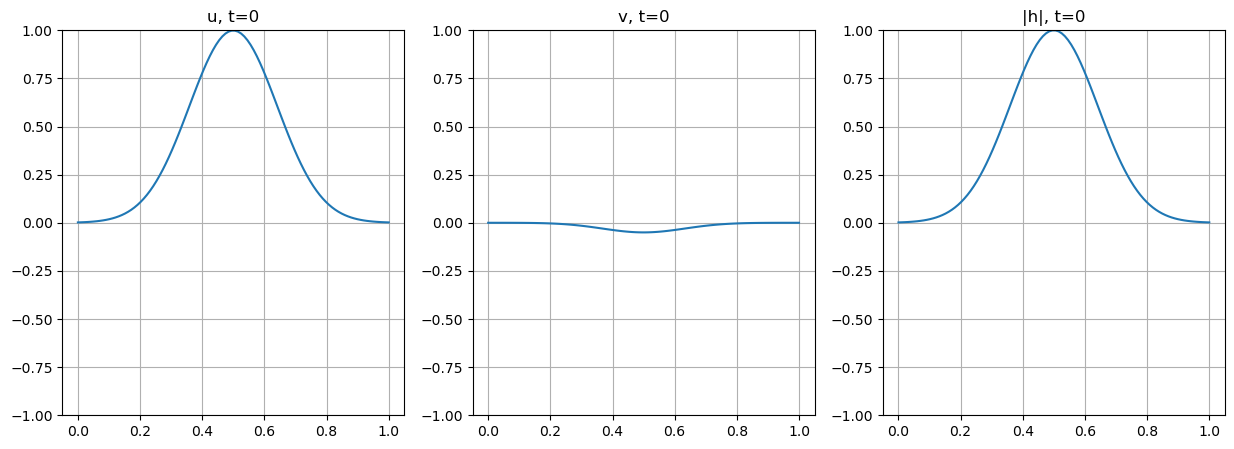

In [7]:
u0_fn = lambda x, t: np.exp(-25*(x-0.5)**2)*np.cos(0.2/epsilon*(x**2-x))
v0_fn = lambda x, t: np.exp(-25*(x-0.5)**2)*np.sin(0.2/epsilon*(x**2-x))
x0 = np.linspace(*domain[:, 0], 100)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([-1, 1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-1, 1])
ax[2].plot(x0, np.sqrt(u0**2+v0**2))
ax[2].set_title("|h|, t=0")
ax[2].grid()
ax[2].set_ylim([-1, 1])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 1000
x_i = random.uniform(subkeys[0], (n_i, 1), jnp.float32, *domain[:, 0])
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)

n_b = 1000
t_b = random.uniform(subkeys[1], (n_b, 1), jnp.float32, *domain[:, 1])
x_lb = jnp.ones_like(t_b)*domain[0, 0]
x_rb = jnp.ones_like(t_b)*domain[1, 0]

n_cx = 10000
# n_ct = 20
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))
# t_c = jnp.linspace(*domain[:, 1], n_ct)
# xt_c = tensor_grid([x_c, t_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])
dataset_BC = namedtuple("dataset_BC", ["l", "r", "t"])

dirichlet = dataset_Dirichlet(x_i, t_i, u_i, v_i)
periodic_bc = dataset_BC(x_lb, x_rb, t_b)
collocation = dataset_Collocation(jnp.vstack([dirichlet.x]),
								 jnp.vstack([dirichlet.t]))
# collocation = dataset_Collocation(jnp.vstack([dirichlet.x, periodic_bc.l, periodic_bc.r, xt_c[:, 0:1]]),
# 								  jnp.vstack([dirichlet.t, periodic_bc.t, periodic_bc.t, xt_c[:, 1:2]]))

class Time_Marching_Generator:
	def __init__(self, key, temporal_domain, batch_size, iterations, update_every):
		self.key = key
		self.domain = temporal_domain
		self.batch_size = batch_size
		self.iterations = iterations
		self._count1 = -1
		self._count2 = update_every
		self.update_every = update_every
		
	def _update(self, key, tmax):
		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self._count2 == self.update_every:
			self._count1 = max(self.iterations, self._count1 + 1)
			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
			self.key, subkey = random.split(self.key)
			self._update(subkey, tmax)
			self._count2 = 0
		else:
			self._count2 += 1
		return self._t

In [8]:
# pre-train

lr = 1e-3
start_iteration = 0
iterations = 50000
print_every = 1000
save_every = 10000
batch_size = {"dirichlet": 256, "bc": 256, "collocation": 2048}
weights = {"c": 1e-1, "d": 1.0, "pbc_d": 1e-1, "pbc_n": 1e-1}

key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
Time = Time_Marching_Generator(subkeys[3], [0, 0], n_cx, iterations, 10)

params = direct_params

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	t_c = next(Time)
	dc = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(jnp.vstack([dc[0], x_c]), jnp.vstack([dc[1], t_c])),
		"periodic_bc": dataset_BC(domain[0, 0]*jnp.ones_like(t_c), domain[1, 0]*jnp.ones_like(t_c), t_c),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "pbc_d", "pbc_n"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/10, 20:32:01, Iteration: 0, Train Loss: 5.9076e-01, c: 1.3514e+00, d: 4.4271e-01, pbc_d: 3.9371e-02, pbc_n: 8.9718e-02
2020/08/10, 20:32:27, Iteration: 1000, Train Loss: 3.0667e-01, c: 2.1940e-02, d: 3.0396e-01, pbc_d: 1.8979e-03, pbc_n: 3.2608e-03
2020/08/10, 20:32:49, Iteration: 2000, Train Loss: 3.3661e-01, c: 1.4288e-02, d: 3.3416e-01, pbc_d: 2.2793e-03, pbc_n: 7.9742e-03
2020/08/10, 20:33:11, Iteration: 3000, Train Loss: 1.2456e-01, c: 1.7971e-01, d: 1.0250e-01, pbc_d: 2.2931e-03, pbc_n: 3.8570e-02
2020/08/10, 20:33:33, Iteration: 4000, Train Loss: 1.0928e-01, c: 1.4246e-01, d: 8.8655e-02, pbc_d: 8.1876e-03, pbc_n: 5.5575e-02
2020/08/10, 20:33:55, Iteration: 5000, Train Loss: 9.2926e-02, c: 1.4933e-01, d: 7.5913e-02, pbc_d: 1.7071e-02, pbc_n: 3.7228e-03
2020/08/10, 20:34:17, Iteration: 6000, Train Loss: 8.3580e-02, c: 2.5173e-01, d: 5.6650e-02, pbc_d: 4.0110e-03, pbc_n: 1.3556e-02
2020/08/10, 20:34:39, Iteration: 7000, Train Loss: 4.4637e-02, c: 2.7102e-01, d: 1.4835e-02, 

In [10]:
lr = 1e-3
start_iteration = 0
iterations = 100000
print_every = 1000
save_every = 10000
batch_size = {"dirichlet": 100, "bc": 100, "collocation": 100}
weights = {"c": 1e-1, "d": 1.0, "pbc_d": 1e-1, "pbc_n": 1e-1}

key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
Time = Time_Marching_Generator(subkeys[3], domain[:, 1], n_cx, iterations, 1)

for iteration in range(start_iteration, start_iteration+iterations+1):
	t_c = next(Time)
	dc = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(jnp.vstack([dc[0], x_c]), jnp.vstack([dc[1], t_c])),
		"periodic_bc": dataset_BC(domain[0, 0]*jnp.ones_like(t_c), domain[1, 0]*jnp.ones_like(t_c), t_c),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "pbc_d", "pbc_n"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/10, 20:51:17, Iteration: 0, Train Loss: 1.2266e+00, c: 1.0888e+01, d: 3.2207e-03, pbc_d: 5.7344e-01, pbc_n: 7.7258e-01
2020/08/10, 20:51:37, Iteration: 1000, Train Loss: 1.0431e-01, c: 9.1469e-01, d: 1.1620e-02, pbc_d: 3.3209e-03, pbc_n: 8.9247e-03
2020/08/10, 20:51:57, Iteration: 2000, Train Loss: 8.4386e-02, c: 7.9700e-01, d: 3.2757e-03, pbc_d: 2.7080e-03, pbc_n: 1.1395e-02
2020/08/10, 20:52:17, Iteration: 3000, Train Loss: 7.9017e-02, c: 7.3314e-01, d: 4.3312e-03, pbc_d: 2.1893e-03, pbc_n: 1.1527e-02
2020/08/10, 20:52:36, Iteration: 4000, Train Loss: 7.7210e-02, c: 7.1002e-01, d: 5.3848e-03, pbc_d: 2.3558e-03, pbc_n: 5.8700e-03
2020/08/10, 20:52:56, Iteration: 5000, Train Loss: 6.8394e-02, c: 6.4000e-01, d: 3.6216e-03, pbc_d: 2.0731e-03, pbc_n: 5.6490e-03
2020/08/10, 20:53:16, Iteration: 6000, Train Loss: 7.9767e-02, c: 7.1908e-01, d: 7.1087e-03, pbc_d: 1.9365e-03, pbc_n: 5.5724e-03
2020/08/10, 20:53:36, Iteration: 7000, Train Loss: 7.3691e-02, c: 6.8061e-01, d: 4.9560e-03, 

2020/08/10, 21:12:15, Iteration: 63000, Train Loss: 1.9942e-02, c: 1.5560e-01, d: 2.4468e-03, pbc_d: 3.6941e-03, pbc_n: 1.5653e-02
2020/08/10, 21:12:36, Iteration: 64000, Train Loss: 1.9465e-02, c: 1.5524e-01, d: 2.3867e-03, pbc_d: 2.1041e-03, pbc_n: 1.3438e-02
2020/08/10, 21:12:56, Iteration: 65000, Train Loss: 2.0803e-02, c: 1.6057e-01, d: 2.8550e-03, pbc_d: 2.6652e-03, pbc_n: 1.6253e-02
2020/08/10, 21:13:15, Iteration: 66000, Train Loss: 2.0713e-02, c: 1.6027e-01, d: 2.1488e-03, pbc_d: 2.1762e-03, pbc_n: 2.3193e-02
2020/08/10, 21:13:35, Iteration: 67000, Train Loss: 1.7782e-02, c: 1.3623e-01, d: 2.2603e-03, pbc_d: 1.9895e-03, pbc_n: 1.6996e-02
2020/08/10, 21:13:55, Iteration: 68000, Train Loss: 1.8627e-02, c: 1.4904e-01, d: 1.9111e-03, pbc_d: 2.4250e-03, pbc_n: 1.5703e-02
2020/08/10, 21:14:15, Iteration: 69000, Train Loss: 1.7758e-02, c: 1.3872e-01, d: 2.5509e-03, pbc_d: 2.2616e-03, pbc_n: 1.1081e-02
2020/08/10, 21:14:35, Iteration: 70000, Train Loss: 1.8366e-02, c: 1.4695e-01, d: 1

In [9]:
from scipy.io import loadmat

uv_true = loadmat("epsilon_1.0.mat")["u"].T

from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
lines = []
for i in range(3):
    line1, = ax[i].plot([], [], lw = 1.5, label = "true")
    line2, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.extend([line1, line2])
    ax[i].set_xlim([0, 1])
    ax[i].set_ylim([-1, 1])
    ax[i].legend()
    ax[i].grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 64)
t_test = jnp.linspace(*domain[:, 1], 101)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_true)
	lines[1].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[2].set_data(x_test, v_true)
	lines[3].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	lines[4].set_data(x_test, np.sqrt(u_true**2+v_true**2))
	lines[5].set_data(x_test, np.sqrt(u_pred**2+v_pred**2))
	ax[2].set_title("|h|, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 200, blit = True)
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
uv_true.shape